In [1]:
# check channels
# time window
# beta values for Adam
import os
raw_data_dir = ''
acc_key = 'acc'
plot_examples = False # notebook file size will increase by between 30 and 60MB if set to True; <1MB otherwise

if  'COLAB_GPU' in os.environ :
    print('Using Google Colab. Setting up environment')
    raw_data_dir = '/content/drive/My Drive/Colab Notebooks/' 
    !pip install mne==0.19.2
    !pip install pyedflib==0.1.15
    print('\n \n To load files from Google Drive, account validation is required.')
    # mount to drive -- files should be located in the /Colab Notebooks directory
    from google.colab import drive
    drive.mount("/content/drive", force_remount=True)
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils

elif 'KAGGLE_URL_BASE' in os.environ:
    acc_key = 'accuracy'
    print('Using Kaggle kernel. Setting up environment')
    !pip install update mne==0.19.2
    !pip install pyedflib==0.1.15
    !pip install chart_studio
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/Data/Raw
    raw_data_dir = 'Raw/'
    
    # download project utilities and data reader 
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/ReadData
    !svn checkout https://github.com/WinAIML/schizophrenia/trunk/MLModels/utils Utils


else: 
    # assuming that a local run will be launched only from a github project; 
    # add the utils and ReadData directories to the temporary path
    if 'HOMEPATH' in os.environ:
        print('Using homepath ' + os.environ['HOMEPATH'])
    raw_data_dir = '../../Data/Raw/'
    
    from pathlib import Path
    import sys
    sys.path.append(os.path.realpath('..'))
    path = Path(os.getcwd())
    sys.path.append(str(path.parent.parent))


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPooling2D, AveragePooling2D, AveragePooling1D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm

import pandas as pd
import numpy as np
import random 

from importlib import reload  #reload(chart_builder)


#################
# import project utilities and the raw data reader
# Kaggle environment does not accept 'utils' as a file, so it must be accessed seperately

import ReadData.RawDataReader as data_reader
if 'KAGGLE_URL_BASE' in os.environ:
    import Utils.ModelBuilder as model_builder
    import Utils.ChartBuilder as chart_builder
else:
    import utils.ModelBuilder as model_builder
    import utils.ChartBuilder as chart_builder


Using Kaggle kernel. Setting up environment
     |████████████████████████████████| 6.4 MB 4.7 MB/s eta 0:00:01
  Attempting uninstall: mne
    Found existing installation: mne 0.20.0
    Uninstalling mne-0.20.0:
      Successfully uninstalled mne-0.20.0
     |████████████████████████████████| 1.1 MB 4.7 MB/s eta 0:00:01
  Created wheel for pyedflib: filename=pyEDFlib-0.1.15-cp36-cp36m-linux_x86_64.whl size=955257 sha256=3564a05e45801a8ad00ebd21ebfb43ed3d3056951bb4a8fed84d0efdcfbeb298
  Stored in directory: /root/.cache/pip/wheels/5b/d3/bd/3fdd15982e9999079344857e8ce9fbdc379d2bd8ad974ea414
Successfully built pyedflib
     |████████████████████████████████| 64 kB 1.6 MB/s eta 0:00:011
A    Raw/Healthy Controls
A    Raw/Healthy Controls/h01.edf
A    Raw/Healthy Controls/h02.edf
A    Raw/Healthy Controls/h03.edf
A    Raw/Healthy Controls/h04.edf
A    Raw/Healthy Controls/h05.edf
A    Raw/Healthy Controls/h06.edf
A    Raw/Healthy Controls/h07.edf
A    Raw/Healthy Controls/h08.edf
A    Raw/

Loading BokehJS ...

In [2]:
ignore_list = ['s12', 's14']  # List of patient files that should be skipped
resolution_hz = 250 # Hz resolution - number of frames per second; 250Hz is the selected value for the EEG dataset
time_window = resolution_hz * 20 # Seconds of data to include in one slice;

all_channels = ['Fp2', 'F8', 'T4', 'T6', 'O2', 'Fp1', 'F7', 'T3', 'T5', 'O1', 'F4',
                'C4', 'P4', 'F3', 'C3', 'P3', 'Fz', 'Cz', 'Pz']
excluded_channels = [ 'T3', 'T5', 'T6', 'O1', 'F3', 'Fp1', 'Fp2', 'P4']#F8'
excluded_channels = []

chans = len(all_channels) - len(excluded_channels)
data = data_reader.get_raw_data(raw_data_dir, resolution_hz, ignore_list, 
                                excluded_channels, time_window)
#np.save('data', data)

Minimum duration:  740


'Shape of raw data for healthy controls: '

(14, 125001, 19)

'Shape of raw data for schizophrenic patients: '

(12, 125001, 19)

Selecting training  / testing / validation sets randomly from patient data
Splitting data into time windows to improve stability of results
(10, 125001, 19)
(250, 5000, 19)
Shape of X_train:  (450, 5000, 19)
Shape of X_validate:  (100, 5000, 19)
Shape of X_test:  (100, 5000, 19)
Removing outliers by channel
Selected indexes for control group: 
Training:  [4, 7, 13, 2, 9, 6, 3, 1, 0, 5]
Testing:  [11, 10]
Validation:  [8, 12]

Selected indexes for patient group: 
Training:  [9, 5, 1, 7, 10, 0, 3, 4]
Testing:  [2, 8]
Validation:  [11, 6]


In [3]:
if plot_examples:
    random_selection =  data_reader.get_random_participants(raw_data_dir, data, ignore_list, resolution_hz)
    chart_builder.plot_random_participants(data, ignore_list, excluded_channels, all_channels, random_selection)


In [4]:
from tensorflow.keras import layers

def LSTM(time_steps, nb_features, chans, nb_classes):

    model=tf.keras.Sequential()
    
    print('chans: ', chans)
    print('nb_features: ', nb_features)

    units = 90
    dropout_rate = 0.002 * units if units < 100 else 0.15

    #model.add(Bidirectional(layers.LSTM(units,
    #                             dropout = dropout_rate),
    #                                                         input_shape=( time_steps, chans)
    #))

    model.add(layers.LSTM(units,
                          input_shape=( time_steps, chans),
                          dropout = dropout_rate,
                         # return_sequences=True
            ))
    #model.add(Bidirectional(layers.LSTM(math.floor(units/2),
    #                             dropout = dropout_rate/2)))
    #
    model.add(Dense(4,kernel_initializer='he_uniform',activation='relu'))
    

    model.add(Dense(nb_classes,activation='softmax'))
    
    return model

In [5]:
####LSTM

#declare model, optimizer and checkpoint file
model = LSTM(time_steps=time_window, chans=chans, nb_features=1, nb_classes=2 )

opt_adam = tf.keras.optimizers.Adam(lr=0.00004, 
                                beta_1=0.99,
                                beta_2=0.999,
                                epsilon=1e-07)
sgd = tf.keras.optimizers.SGD(lr=0.01)

lstm_checkpoint = '/tmp/LSTM_checkpoint.h5'

fitted_model_lstm = model_builder.construct_and_run_model(data, model, opt_adam, lstm_checkpoint, epochs=200, batch_size=32)


chans:  19
nb_features:  1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90)                39600     
_________________________________________________________________
dense (Dense)                (None, 4)                 364       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
Total params: 39,974
Trainable params: 39,974
Non-trainable params: 0
_________________________________________________________________
Train on 450 samples, validate on 100 samples
Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.67395, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 9s - loss: 0.6980 - accuracy: 0.4822 - rmse: 0.5049 - val_loss: 0.6739 - val_accuracy: 0.5900 - val_rmse: 0.4865
Epoch 2/200

Epoch 00002: val_loss improved from 0.67395 to 0.67364, saving model

Epoch 33/200

Epoch 00033: val_loss improved from 0.65410 to 0.65309, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6742 - accuracy: 0.6133 - rmse: 0.4895 - val_loss: 0.6531 - val_accuracy: 0.7100 - val_rmse: 0.4794
Epoch 34/200

Epoch 00034: val_loss improved from 0.65309 to 0.65202, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6752 - accuracy: 0.6156 - rmse: 0.4882 - val_loss: 0.6520 - val_accuracy: 0.6900 - val_rmse: 0.4789
Epoch 35/200

Epoch 00035: val_loss improved from 0.65202 to 0.65087, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6732 - accuracy: 0.5933 - rmse: 0.4916 - val_loss: 0.6509 - val_accuracy: 0.6900 - val_rmse: 0.4784
Epoch 36/200

Epoch 00036: val_loss improved from 0.65087 to 0.64969, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6706 - accuracy: 0.6378 - rmse: 0.4892 - val_loss: 0.6497 - val_accuracy: 0.6900 - val_rmse: 0.4778
Epoch 37/200

Epoch 00037: val_loss improved from 0.64969 to 0.64853

Epoch 69/200

Epoch 00069: val_loss improved from 0.61173 to 0.61059, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6427 - accuracy: 0.6489 - rmse: 0.4681 - val_loss: 0.6106 - val_accuracy: 0.7300 - val_rmse: 0.4622
Epoch 70/200

Epoch 00070: val_loss improved from 0.61059 to 0.60935, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6401 - accuracy: 0.6533 - rmse: 0.4723 - val_loss: 0.6094 - val_accuracy: 0.7300 - val_rmse: 0.4618
Epoch 71/200

Epoch 00071: val_loss improved from 0.60935 to 0.60805, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.6385 - accuracy: 0.6711 - rmse: 0.4714 - val_loss: 0.6081 - val_accuracy: 0.7200 - val_rmse: 0.4615
Epoch 72/200

Epoch 00072: val_loss improved from 0.60805 to 0.60666, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 0.6369 - accuracy: 0.6578 - rmse: 0.4664 - val_loss: 0.6067 - val_accuracy: 0.7200 - val_rmse: 0.4611
Epoch 73/200

Epoch 00073: val_loss improved from 0.60666 to 0.60520

Epoch 105/200

Epoch 00105: val_loss improved from 0.50967 to 0.50337, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.5738 - accuracy: 0.6889 - rmse: 0.4282 - val_loss: 0.5034 - val_accuracy: 0.7600 - val_rmse: 0.4362
Epoch 106/200

Epoch 00106: val_loss improved from 0.50337 to 0.49762, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 3s - loss: 0.5760 - accuracy: 0.6644 - rmse: 0.4537 - val_loss: 0.4976 - val_accuracy: 0.7500 - val_rmse: 0.4365
Epoch 107/200

Epoch 00107: val_loss improved from 0.49762 to 0.49232, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 0.5658 - accuracy: 0.6933 - rmse: 0.4342 - val_loss: 0.4923 - val_accuracy: 0.7600 - val_rmse: 0.4342
Epoch 108/200

Epoch 00108: val_loss improved from 0.49232 to 0.48703, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 0.5555 - accuracy: 0.7111 - rmse: 0.4318 - val_loss: 0.4870 - val_accuracy: 0.7500 - val_rmse: 0.4306
Epoch 109/200

Epoch 00109: val_loss improved from 0.48703 to 0.


Epoch 00140: val_loss improved from 0.43577 to 0.43485, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 0.4933 - accuracy: 0.7422 - rmse: 0.4075 - val_loss: 0.4349 - val_accuracy: 0.8100 - val_rmse: 0.3859
Epoch 141/200

Epoch 00141: val_loss improved from 0.43485 to 0.43440, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 0.5000 - accuracy: 0.7311 - rmse: 0.4042 - val_loss: 0.4344 - val_accuracy: 0.8100 - val_rmse: 0.3839
Epoch 142/200

Epoch 00142: val_loss improved from 0.43440 to 0.43409, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 0.4931 - accuracy: 0.7467 - rmse: 0.4210 - val_loss: 0.4341 - val_accuracy: 0.8100 - val_rmse: 0.3817
Epoch 143/200

Epoch 00143: val_loss did not improve from 0.43409
450/450 - 4s - loss: 0.5042 - accuracy: 0.7400 - rmse: 0.4039 - val_loss: 0.4349 - val_accuracy: 0.8100 - val_rmse: 0.3777
Epoch 144/200

Epoch 00144: val_loss did not improve from 0.43409
450/450 - 3s - loss: 0.5060 - accuracy: 0.7400 - rmse: 0.

Epoch 177/200

Epoch 00177: val_loss improved from 0.41658 to 0.41633, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 0.4788 - accuracy: 0.7756 - rmse: 0.3979 - val_loss: 0.4163 - val_accuracy: 0.8100 - val_rmse: 0.3722
Epoch 178/200

Epoch 00178: val_loss improved from 0.41633 to 0.41601, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 0.4809 - accuracy: 0.7711 - rmse: 0.4103 - val_loss: 0.4160 - val_accuracy: 0.8100 - val_rmse: 0.3723
Epoch 179/200

Epoch 00179: val_loss improved from 0.41601 to 0.41563, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 0.4712 - accuracy: 0.7778 - rmse: 0.3956 - val_loss: 0.4156 - val_accuracy: 0.8100 - val_rmse: 0.3723
Epoch 180/200

Epoch 00180: val_loss improved from 0.41563 to 0.41525, saving model to /tmp/LSTM_checkpoint.h5
450/450 - 4s - loss: 0.4700 - accuracy: 0.7844 - rmse: 0.4001 - val_loss: 0.4153 - val_accuracy: 0.8100 - val_rmse: 0.3722
Epoch 181/200

Epoch 00181: val_loss improved from 0.41525 to 0.

Diagrammed History of Model Metrics


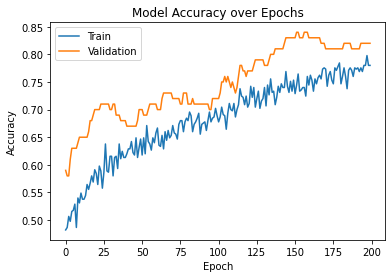

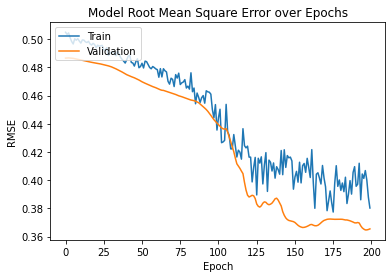

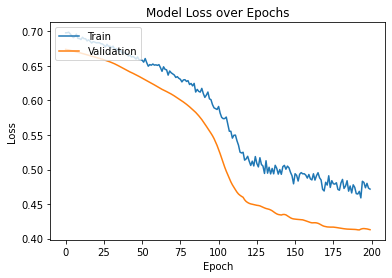

In [6]:
model_builder.print_model_metrics(fitted_model_lstm, acc_key)


In [ ]:
!pip freeze

In [ ]:
from platform import python_version

print(python_version())